# Assignment 3: LDA Topic Modeling

## Note
Installing Tomotopy locally can return an error, if that's the case run this notebook on Google Colab

## Research Background

LDA is a popular topic modeling algorithm widely used in the fields of Digital Humanities and Social Sciences. In the field of political communication, topic modeling is often applied for analyzing politicians Twitter/X posts, identitying thematic patterns or topics revolving around their posts.

For this assignment, students will work with tweets from two USA politicians, Donald Trump and Bernie Sanders, who are often regarded as right-wing populist and left-wing populist respectively. Right-wing populism often emphasizes nationalism, anti-immigration policies, and a critique of global elites from a culturally conservative perspective, focusing on preserving traditional values and social hierarchies. Left-wing populism prioritizes economic inequality, advocating for the redistribution of wealth, expansion of social services, and empowerment of the working class against the capitalist elite. While both forms of populism appeal to the "common people" against perceived elites and established structures, they diverge significantly in their identification of the elites, proposed solutions, and core ideologies. For a more detailed explanation, you can read the chapter by Macaulay (2019) "Bernie and The Donald: A comparison of left-and right-wing populist discourse" (full reference below).

**Research Questions**
1. What topics are revolving around Donald Trump and Bernie Sanders' posts separately?
2. What are the topic differences between Trump (right-wing popoulist) and Sanders (left-wing populist)?

**Aim:**
1. The first aim of the assignment is to conduct LDA topic modeling. Identify thematic patterns or politics revolving around Trump or Sanders's posts.
2. The second aim is to critically evaluate the results of topic modeling. Try different numbers of topics to see with which settings the topics are more coherent. Critically reflect on the results of LDA topic modeling, discussing them in relation to existing theories about populism.

**Data**
Two datasets are prepared for this assginment. Tweets from Trump and tweets from Sanders. Students are asked to work on these two datasets.

**Methods**
1. Word segamentation
2. Removing stopwords
3. LDA topic modeling
4. Topic evaulation (coherence and human evaluation)
5. Visualization of results.

**References**
1. Macaulay, M. (2019). Bernie and the Donald: A comparison of Left-and Right-wing populist discourse. *Populist discourse: International perspectives*, 165-195.





## Setup

### Q1. Install necessary libraries, including `tomotopy` and `little_mallet_wrapper`, and import them

In [1]:
# Q1 (code)

# Install tomotopy and little_mallet_wrapper
!pip install tomotopy
!pip install little_mallet_wrapper

# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 1.4 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
# Import necessary libraries
import tomotopy as tp # for toping modeling
import little_mallet_wrapper # for functions concerning topic modeling
import seaborn # for data visualization
import glob # for finding pathnames
from pathlib import Path # for working with file system paths
import pandas as pd # for data wrangling

## Data preprocessing

### Q2. Load the two datasets and concatenate them

The goal is to run topic modelling on the combined dataset of Sanders and Trump's tweets

In [3]:
# Q2 (code)

# Set the file paths for the datasets
trump_tweets_path = '/content/drive/My Drive/A3/trump_tweets.csv'
sanders_tweets_path = '/content/drive/My Drive/A3/sanders_tweets.csv'

# Load the datasets
trump_tweets = pd.read_csv(trump_tweets_path)
sanders_tweets = pd.read_csv(sanders_tweets_path)

# Concatenate the datasets
combined_tweets = pd.concat([trump_tweets, sanders_tweets], ignore_index=True)

# Display the shape of the combined dataset
print("Combined dataset shape:", combined_tweets.shape)

# Display the first few rows of the combined DataFrame
combined_tweets.head()


Combined dataset shape: (30371, 4)


,Username,TweetId,Title,Content
0,@realDonaldTrump,822421390125043713,@realDonaldTrump_822421390125043713,It all begins today! I will see you at 11:00 ...
1,@realDonaldTrump,822501803615014918,@realDonaldTrump_822501803615014918,Today we are not merely transferring power fr...
2,@realDonaldTrump,822501939267141634,@realDonaldTrump_822501939267141634,"power from Washington, D.C. and giving it bac..."
3,@realDonaldTrump,822502135233384448,@realDonaldTrump_822502135233384448,What truly matters is not which party control...
4,@realDonaldTrump,822502270503972872,@realDonaldTrump_822502270503972872,"January 20th 2017, will be remembered as the ..."


### Q3. Clean the data

Transform all tweets to lowercase, remove stopwords, punctuation, and numbers. Add the processed text to a list called `training_data`.
Create a list with the content of the tweets (`original_texts`) and a list that allows you to identify both the author of the tweet and its ID (`titles`).


In [4]:
# Q3 (code)
# Import necessary libraries
import re # for regular expression operations
import nltk
from nltk.corpus import stopwords #Imports the stopwords corpus from nltk
from nltk.tokenize import word_tokenize # for tokenizing text into words
import string # Imports the string module for cleaning punctuation

In [5]:
#Downloads the stopwords corpus
nltk.download('stopwords')

# Download the 'punkt' tokenizer models from NLTK's repository
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
# Creates a set of English stopwods
stop_words = set(stopwords.words('english'))

# Creates a set of punctuation characters
punctuation = set(string.punctuation)

In [7]:
def preprocess_text(text):
    # Eliminate URLs, user mentions, special characters, and numeric sequences
    processed_text = re.sub(r"http\S+|www\S+|https\S+|\/\/t|co\/|\@\w+|realdonaldtrump|[\W\d_]+", ' ', text, flags=re.MULTILINE)
    # Tokenize the processed text into lowercase words
    tokens = word_tokenize(processed_text.lower())
    # Remove stopwords, punctuation, and numbers
    filtered_tokens = [token for token in tokens if token not in stop_words and token not in punctuation and not token.isdigit()]
    # Join tokens back into text
    return ' '.join(filtered_tokens)

In [8]:
# Store the processed text in a list named training_data
training_data = [preprocess_text(content) for content in combined_tweets['Content']]
# Create a list with the content of the tweets
original_texts = list(combined_tweets['Content'])
# Create a list of titles by combining the 'Username' and 'TweetId' columns for each row in the DataFrame df_concat
titles = [f"{row['Username']}_{row['TweetId']}" for _, row in combined_tweets.iterrows()]

In [9]:
len(training_data), len(original_texts), len(titles)

(30371, 30371, 30371)

## LDA topic modelling

### Q4. Train a an LDA topic model with `tomotopy`

In [10]:
# Q4 (code)
# Number of topics to return
num_topics = 10
# Numer of topic words to print out
num_topic_words = 10

# Intialize the model
model = tp.LDAModel(k=num_topics)

# Add each document to the model, after splitting it up into words
for text in training_data:
    model.add_doc(text.strip().split())

print("Topic Model Training...\n\n")
# Iterate over the data 10 times
iterations = 10
for i in range(0, 100, iterations):
    model.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model.ll_per_word}')


Topic Model Training...


Iteration: 0	Log-likelihood: -9.179199969204172
Iteration: 10	Log-likelihood: -8.80867926957997
Iteration: 20	Log-likelihood: -8.63144797953828
Iteration: 30	Log-likelihood: -8.539398450899183
Iteration: 40	Log-likelihood: -8.494444949190978
Iteration: 50	Log-likelihood: -8.455328342167098
Iteration: 60	Log-likelihood: -8.430899585713396
Iteration: 70	Log-likelihood: -8.408918699150902
Iteration: 80	Log-likelihood: -8.394375895326217
Iteration: 90	Log-likelihood: -8.384296433654239


### Q5. Print out the top words for each topic and manually evaluate their coherence


In [14]:
# Q5a (code)

# Print out top 10 words for each topic
print("\nTopic Model Results:\n\n")

topics = []
topic_individual_words = []
for topic_number in range(0, num_topics):
    topic_words = ' '.join(word for word, prob in model.get_topic_words(topic_id=topic_number, top_n=num_topic_words))
    topics.append(topic_words)
    topic_individual_words.append(topic_words.split())
    print(f"✨Topic {topic_number}✨\n\n{topic_words}\n")


Topic Model Results:


✨Topic 0✨

great vote thank state amp job total endorsement strong military

✨Topic 1✨

border must people country war united states security wall trump

✨Topic 2✨

great china amp u many much good big trade would

✨Topic 3✨

news fake democrats amp media never even impeachment nothing president

✨Topic 4✨

rt realdonaldtrump president trump thank great today america whitehouse american

✨Topic 5✨

rt trump realdonaldtrump president fbi obama new general amp former

✨Topic 6✨

tax trump republicans million billion working people bill americans need

✨Topic 7✨

great thank rt tonight foxnews p see florida puerto hurricane

✨Topic 8✨

rt biden amp joe realdonaldtrump president law coronavirus police left

✨Topic 9✨

people must health care country workers right americans american need



**Manual Evaluation of Topic Coherence:**

The topics overall exhibit moderate to good coherence with their respective themes. However, the coherence between topics varies, with some demonstrating clearer thematic consistency and relevance among keywords than others.

Topic 0 - Gratitude and Endorsements: This topic shows high coherence, with keywords like "thank," "endorsement," and "strong military" aligning closely with expressions of gratitude and political support.

Topic 1 - National Security and Immigration: Discussions on national security and immigration policies exhibit good coherence, indicated by keywords such as "border," "security," and "wall," which are closely related to border control and security measures.

Topic 2 - Trade Relations with China: The coherence in this topic is strong, characterized by keywords like "trade," "China," and "economic," reflecting focused discussions on trade relations and economic policies with China.

Topic 3 - Media Criticism and Political Narratives: This topic demonstrates moderate coherence, with keywords like "fake news," "impeachment," and "media" suggesting debates on media narratives and political controversies.

Topic 4 - Presidential Activities and White House Events: Discussions centered around President Trump's activities show good coherence, with keywords like "realdonaldtrump," "president," and "whitehouse" indicating discussions on presidential announcements and official events.

Topic 5 - Administration Discussions and Policy Comparisons: This topic exhibits moderate coherence, with keywords such as "trump," "fbi," and "obama" suggesting comparisons between presidential administrations and government policies.

Topic 6 - Economic Policies and Workforce Support: Coherence in this topic is strong, reflected by keywords like "tax," "working," and "americans" aligning closely with discussions on economic policies and workforce support initiatives.

Topic 7 - Reactions to News Events: Discussions related to reactions and news events demonstrate moderate coherence, indicated by keywords like "tonight," "hurricane," and "foxnews" reflecting responses to current events and media coverage.

Topic 8 - Contrasts with Political Opponents: This topic shows good coherence, with keywords like "biden," "law," and "coronavirus" highlighting debates on contrasting political approaches and policy stances.

Topic 9 - Healthcare and Workers' Rights: Discussions on healthcare policies and workers' rights demonstrate moderate coherence, with keywords such as "health," "care," and "workers" indicating focused debates on healthcare reform and labor issues.

In summary, while most topics exhibit reasonable coherence with their respective themes, there are variations in coherence levels across topics. Topics closely related to specific policy areas or issues (e.g., trade relations, economic policies) demonstrate higher coherence, whereas topics covering broader or more ambiguous subjects may exhibit slightly lower coherence. A deeper contextual understanding may be necessary to fully grasp the relevance and coherence of certain topics within the dataset.

In [11]:
# Q5b (words)
# Describe what each topic is about. What ideas, values, or situations do these keywords refer to?

✨Topic 0✨
This topic emphasizes expressions of gratitude and support, often related to political endorsements and achievements. It includes keywords like "thank," "endorsement," "strong," and "military," indicating discussions around supporting state initiatives, military strength, and recognizing achievements.

✨Topic 1✨
This topic revolves around discussions concerning national security and immigration policies, with keywords such as "border," "security," "war," and "wall." These keywords suggest debates and policies related to border control, national defense, and the construction of a border wall.

✨Topic 2✨
This topic focuses on trade relations and economic policies, particularly with China. Keywords like "trade," "China," "economic," and "deal" indicate discussions around international trade, economic impact, and negotiations with China.

✨Topic 3✨
This topic reflects criticisms of media and political opponents, featuring keywords like "fake," "news," "impeachment," and "president." It highlights skepticism towards media reporting, debates on impeachment proceedings, and political narratives regarding the presidency.

✨Topic 4✨
This topic centers around President Trump and White House events, with keywords like "realdonaldtrump," "president," "today," and "whitehouse." It includes discussions related to presidential activities, announcements, and events at the White House.

✨Topic 5✨
This topic involves discussions about President Trump's administration, including mentions of agencies like the FBI and comparisons with former President Obama. Keywords like "trump," "fbi," "obama," and "president" suggest discussions on government policies and political figures.

✨Topic 6✨
This topic focuses on economic policies and support for working Americans, with keywords such as "tax," "working," "bill," and "americans." It includes debates on tax reforms, economic bills, and initiatives aimed at benefiting the workforce.

✨Topic 7✨
This topic includes expressions of gratitude and reactions to news events, featuring keywords like "thank," "tonight," "foxnews," and "hurricane." It reflects acknowledgments, news updates, and reactions to current events and media coverage.

✨Topic 8✨
This topic involves discussions comparing President Trump with political opponents like Joe Biden, focusing on law enforcement, COVID-19 response, and political ideologies. Keywords like "biden," "law," "coronavirus," and "police" indicate debates on policy approaches and political contrasts.

✨Topic 9✨
This topic centers around healthcare and workers' rights, highlighting discussions on healthcare systems, employment conditions, and the well-being of American citizens. Keywords like "health," "care," "workers," and "rights" suggest debates on healthcare policies and labor issues.

## Topic coherence

Use `tomotopy`'s [`.coherence()`](https://bab2min.github.io/tomotopy/v0.10.0/en/coherence.html) function to automatically calculate the topic coherence.

The coherence value can vary from `0` (no coherence) to `1` (maximum coherence). Interpret the results and, if needed, retrain the model using a different number of topics.

In [15]:
# Initial coherence score (topic number is 10)
# There are different metrics for coherence, we choose `c_v`

coh = tp.coherence.Coherence(model, coherence='c_v')
average_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model.k)]

print('==== Coherence : {} ===='.format('c_v'))
print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
print()

==== Coherence : c_v ====
Average: 0.5481422200798989 
Per Topic: [0.6392641320824624, 0.4961779184639454, 0.5413884490728378, 0.6022497266530991, 0.46402018889784813, 0.5084954366087914, 0.570129606127739, 0.49756703674793246, 0.5276541113853455, 0.6344755947589874]



In [16]:
# Retrain the model (Change topic numbers: 15)
# Number of topics to return
num_topics = 15
# Numer of topic words to print out
num_topic_words = 10

In [17]:
# Intialize the model
model1 = tp.LDAModel(k=num_topics)

# Add each document to the model
for text in training_data:
    model1.add_doc(text.strip().split())

print("Topic Model Training...\n\n")
# Iterate over the data 10 times
iterations = 10
for i in range(0, 100, iterations):
    model1.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model1.ll_per_word}')

Topic Model Training...


Iteration: 0	Log-likelihood: -9.29087993067091
Iteration: 10	Log-likelihood: -8.85194134771031
Iteration: 20	Log-likelihood: -8.681591621197047
Iteration: 30	Log-likelihood: -8.592193147125304
Iteration: 40	Log-likelihood: -8.532873795817949
Iteration: 50	Log-likelihood: -8.496235792648132
Iteration: 60	Log-likelihood: -8.467186051860525
Iteration: 70	Log-likelihood: -8.440342260728983
Iteration: 80	Log-likelihood: -8.421724761846669
Iteration: 90	Log-likelihood: -8.407990814224942


In [18]:
# change the topic number to 15
# There are different metrics for coherence, we choose `c_v`

coh = tp.coherence.Coherence(model1, coherence='c_v')
average_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model1.k)]

print('==== Coherence : {} ===='.format('c_v'))
print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
print()

==== Coherence : c_v ====
Average: 0.5630632113091026 
Per Topic: [0.6030335575342178, 0.586939561367035, 0.3949845261871815, 0.48680886924266814, 0.467527990299277, 0.5230880856513977, 0.6210364520549774, 0.6660140007734299, 0.5087588161230088, 0.6368895277380944, 0.5204346060752869, 0.7347817540168762, 0.5093496590852737, 0.5579893350601196, 0.6283114284276963]



In [19]:
# Retrain the model (Change topic numbers: 20)
# Number of topics to return
num_topics = 20
# Numer of topic words to print out
num_topic_words = 10
# Intialize the model
model2 = tp.LDAModel(k=num_topics)

# Add each document to the model, after splitting it up into words
for text in training_data:
    model2.add_doc(text.strip().split())

print("Topic Model Training...\n\n")
# Iterate over the data 10 times
iterations = 10
for i in range(0, 100, iterations):
    model2.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model2.ll_per_word}')

Topic Model Training...


Iteration: 0	Log-likelihood: -9.404580879657436
Iteration: 10	Log-likelihood: -8.943709652779702
Iteration: 20	Log-likelihood: -8.75210077689078
Iteration: 30	Log-likelihood: -8.65604337211624
Iteration: 40	Log-likelihood: -8.592267583971529
Iteration: 50	Log-likelihood: -8.545385862653974
Iteration: 60	Log-likelihood: -8.514523302953902
Iteration: 70	Log-likelihood: -8.485860010240566
Iteration: 80	Log-likelihood: -8.464037924738554
Iteration: 90	Log-likelihood: -8.441870258804553


In [20]:
# change the topic number to 20
# There are different metrics for coherence, we choose `c_v`

coh = tp.coherence.Coherence(model2, coherence='c_v')
average_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model2.k)]

print('==== Coherence : {} ===='.format('c_v'))
print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
print()

==== Coherence : c_v ====
Average: 0.5707939968816935 
Per Topic: [0.5286748617887497, 0.6045342303812504, 0.5948794156312942, 0.7342484384775162, 0.5186323374509811, 0.577997275441885, 0.5256362617015838, 0.5054473623633384, 0.5362831190228462, 0.6034816712141037, 0.545894268155098, 0.7097533002495766, 0.6850403547286987, 0.6099733889102936, 0.583583765476942, 0.5397471521049738, 0.4491792231798172, 0.5037020176649094, 0.4505446121096611, 0.6086468815803527]



In [21]:
# Retrain the model (Change topic numbers: 25)
# Number of topics to return
num_topics = 25
# Numer of topic words to print out
num_topic_words = 10
# Intialize the model
model3 = tp.LDAModel(k=num_topics)

# Add each document to the model, after splitting it up into words
for text in training_data:
    model3.add_doc(text.strip().split())

print("Topic Model Training...\n\n")
# Iterate over the data 10 times
iterations = 10
for i in range(0, 100, iterations):
    model3.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model3.ll_per_word}')

Topic Model Training...


Iteration: 0	Log-likelihood: -9.483644818519869
Iteration: 10	Log-likelihood: -8.980873637084596
Iteration: 20	Log-likelihood: -8.770276765876742
Iteration: 30	Log-likelihood: -8.65968520085154
Iteration: 40	Log-likelihood: -8.589758840311323
Iteration: 50	Log-likelihood: -8.53235254059212
Iteration: 60	Log-likelihood: -8.48708619090638
Iteration: 70	Log-likelihood: -8.457339850867552
Iteration: 80	Log-likelihood: -8.433705845973781
Iteration: 90	Log-likelihood: -8.40619415918159


In [22]:
# change the topic number to 25
# There are different metrics for coherence, we choose `c_v`

coh = tp.coherence.Coherence(model3, coherence='c_v')
average_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model3.k)]

print('==== Coherence : {} ===='.format('c_v'))
print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
print()

==== Coherence : c_v ====
Average: 0.5916700500845908 
Per Topic: [0.4920634239912033, 0.4440867751836777, 0.7548749536275864, 0.5883925151079893, 0.6496538519859314, 0.5377547785639762, 0.6912961855530739, 0.556754170358181, 0.5446788601577282, 0.5340549439191818, 0.499391233921051, 0.7124984651803971, 0.5300467398017645, 0.6297538071870804, 0.5376209825277328, 0.6309096276760101, 0.5470302850008011, 0.6660298347473145, 0.4621819153428078, 0.6077814996242523, 0.5500529631972313, 0.6408080697059632, 0.5462053760886192, 0.6877402842044831, 0.7500897094607353]



In [23]:
# Retrain the model (Change topic numbers: 30)
# Number of topics to return
num_topics = 30
# Numer of topic words to print out
num_topic_words = 10
# Intialize the model
model4 = tp.LDAModel(k=num_topics)

# Add each document to the model, after splitting it up into words
for text in training_data:
    model4.add_doc(text.strip().split())

print("Topic Model Training...\n\n")
# Iterate over the data 10 times
iterations = 10
for i in range(0, 100, iterations):
    model4.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model4.ll_per_word}')

Topic Model Training...


Iteration: 0	Log-likelihood: -9.526654672461554
Iteration: 10	Log-likelihood: -9.010397368623543
Iteration: 20	Log-likelihood: -8.803562553430607
Iteration: 30	Log-likelihood: -8.686410157733967
Iteration: 40	Log-likelihood: -8.611199078852602
Iteration: 50	Log-likelihood: -8.554508039234818
Iteration: 60	Log-likelihood: -8.50826071571699
Iteration: 70	Log-likelihood: -8.477627753577496
Iteration: 80	Log-likelihood: -8.447278543607057
Iteration: 90	Log-likelihood: -8.425343430013418


In [24]:
# change the topic number to 30
# There are different metrics for coherence, we choose `c_v`

coh = tp.coherence.Coherence(model4, coherence='c_v')
average_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model3.k)]

print('==== Coherence : {} ===='.format('c_v'))
print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
print()

==== Coherence : c_v ====
Average: 0.5794038474311431 
Per Topic: [0.6811137951910495, 0.7597695469856263, 0.5925054788589478, 0.6256049863994122, 0.49821560382843016, 0.5593701273202896, 0.546479095518589, 0.576610391587019, 0.6652405172586441, 0.6228853583335876, 0.5778489381074905, 0.6705860808491707, 0.7067230433225632, 0.5829709649085999, 0.47796696424484253, 0.6900931149721146, 0.5178347051143646, 0.5444894790649414, 0.49001604989171027, 0.5690747022628784, 0.4948292255401611, 0.5388649947941303, 0.41845640167593956, 0.5946665771305562, 0.5294068142771721]



### Q6. Interpret topic coherence

Report the following:
- number of topics you initially used to train the model and the coherence score you got
- changes made to the number of topics and new coherence scores obtained

In [ ]:
# Q6 (words)


* Initial number of topics: 10
* Average coherence score: 0.5481422200798989

For the initial experiment, this coherence score suggests a moderate level of coherence among the topics generated by the model.

Change the topic numbers:

* Number of topics: 15
* Average coherence score: 0.5630632113091026.

In the first modification, the number of topics was increased to 15, resulting in an improved average coherence score. This indicates a slight enhancement in the coherence of the topics compared to the initial experiment.

* Number of topics: 20
* Average coherence score: 0.5707939968816935.

In the second modification, the number of topics was further increased to 20, leading to a higher average coherence. This adjustment reflects a more coherent topic model compared to the previous experiments.

* Number of topics: 25
* Average coherence score: 0.5916700500845908.

In the third modification, increasing the number of topics to 25 resulted in a higher average coherence score, indicating improved topic coherence.

* Number of topics: 30
* Average coherence score: 0.5794038474311431.

In the final modification, increasing the number of topics to 30 yielded a slightly lower average coherence score of 0.5794 compared to the experiment with 25 topics.

**Conclusion:**

These experiments demonstrate that increasing the number of topics generally enhances the coherence of the topics generated by the model. However, there may be diminishing returns or fluctuations in coherence scores as the number of topics exceeds a certain threshold. In this case, the most coherent arrangement of topics was achieved with 25 topics, which yielded the highest average coherence score of 0.5916.







### X1. Optional question 1
(This question is not compulsory, it only allows you to get an extra point.)

Create a function to plot the average coherence for models with different number of topics.

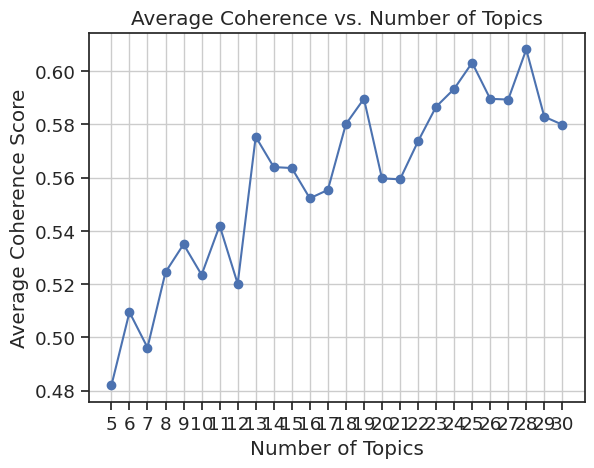

In [27]:
# X1 (code)
# Tip: y = average topic coherence; x = number of topics in the model

import matplotlib.pyplot as plt

def plot_coherence(start_topic_num, end_topic_num, training_data):
    average_coherence_list = [] # Initialize an empty list
    topics_num_list = range(start_topic_num, end_topic_num + 1) # This list contains the topic number range

    for topic_num in topics_num_list:  # Iterate over each topic number
        model5 = tp.LDAModel(k=topic_num)

        for tweet in training_data:
            model5.add_doc(tweet.strip().split())

        iteration_num = 10 # Set the number of training iterations

        for i in range(0, iteration_num):
            model5.train(iteration_num)

        coh = tp.coherence.Coherence(model5, coherence='c_v')
        average_coherence_list.append(coh.get_score())

    plt.plot(topics_num_list, average_coherence_list, marker='o')
    plt.title('Average Coherence vs. Number of Topics')
    plt.xlabel('Number of Topics')
    plt.ylabel('Average Coherence Score')
    plt.xticks(topics_num_list)  # Ensure integer ticks on x-axis
    plt.grid(True) # Add grid lines for better readability
    plt.show()

# plot coherence scores for topic numbers from 5 to 30
plot_coherence(5, 30, training_data)

### Q7. Topic distributions
Calculate the topic distributions for all tweets and get the top documents for some topics (between 2 and 5) that you think could be more representative of Sanders or Trump.

In [28]:
# I will use the model with 25 topics trained before due to its highest coherence score
# Retrieve topic distributions for all documents
topic_distributions = [list(doc.get_topic_dist()) for doc in model3.docs]

In [29]:
# Number of topics to return
num_topics = 25
# Numer of topic words to print out
num_topic_words = 10

In [30]:
# Print out top 10 words for each topic for the new topic model (topic = 25)
print("\nTopic Model Results:\n\n")

topics = []
topic_individual_words = []
for topic_number in range(0, num_topics):
    topic_words = ' '.join(word for word, prob in model3.get_topic_words(topic_id=topic_number, top_n=num_topic_words))
    topics.append(topic_words)
    topic_individual_words.append(topic_words.split())
    print(f"✨Topic {topic_number}✨\n\n{topic_words}\n")


Topic Model Results:


✨Topic 0✨

new small help businesses need workers get york amp covid

✨Topic 1✨

great thank house white america new forward today make big

✨Topic 2✨

great total endorsement strong military complete amp amendment vets second

✨Topic 3✨

news fake media amp people even never cnn story like

✨Topic 4✨

democrats senate house impeachment rt republicans pelosi republican vote dems

✨Topic 5✨

law federal must people government puerto justice rico police enforcement

✨Topic 6✨

rt president schiff call trump case impeachment ukraine whistleblower jim

✨Topic 7✨

great vote win big get state republican amp going governor

✨Topic 8✨

change must people climate energy trump us together fossil stand

✨Topic 9✨

trump president korea rt donald north meeting amp administration obama

✨Topic 10✨

war u iran trump military united end must states us

✨Topic 11✨

wall street debt college public student school free education make

✨Topic 12✨

would amp biden joe left radical 

In [33]:
# Compute the topic distributions for all tweets
# Initialize a list to store the results
topic_results = []

# Iterate over the titles and topic distributions
for title, topic_distribution in zip(titles, topic_distributions):
    topic_results.append({'document': title, 'topic_distribution': topic_distribution})

# Create a DataFrame from the results
df = pd.DataFrame(topic_results)

# Extract the topic words as column names
column_names = [f"Topic {number} {' '.join(topic[:4])}" for number, topic in enumerate(topic_individual_words)]

# Split the topic distributions into separate columns
df[column_names] = pd.DataFrame(df['topic_distribution'].tolist(), index=df.index)

# Drop the 'topic_distribution' column
df = df.drop('topic_distribution', axis='columns')

# Display the DataFrame
df


,document,Topic 0 new small help businesses,Topic 1 great thank house white,Topic 2 great total endorsement strong,Topic 3 news fake media amp,Topic 4 democrats senate house impeachment,Topic 5 law federal must people,Topic 6 rt president schiff call,Topic 7 great vote win big,Topic 8 change must people climate,...,Topic 15 health care people right,Topic 16 jobs economy ever years,Topic 17 tax billionaires trump wealth,Topic 18 states united country court,Topic 19 rt trump biden joe,Topic 20 rt realdonaldtrump president trump,Topic 21 rt whitehouse president coronavirus,Topic 22 drug american today lives,Topic 23 workers wage pay must,Topic 24 russia collusion witch hunt
0,@realDonaldTrump_822421390125043713,0.005486,0.013100,0.004998,0.013264,0.009981,0.007643,0.009683,0.105990,0.206129,...,0.108308,0.010800,0.006809,0.408247,0.006145,0.011302,0.004500,0.007881,0.006316,0.006938
1,@realDonaldTrump_822501803615014918,0.003928,0.009380,0.003579,0.080490,0.078139,0.360434,0.006934,0.004900,0.005610,...,0.006560,0.078725,0.004876,0.008349,0.075392,0.079084,0.003222,0.005643,0.004522,0.004967
2,@realDonaldTrump_822501939267141634,0.005486,0.310540,0.004998,0.013264,0.109127,0.007643,0.009683,0.006843,0.007835,...,0.009161,0.010800,0.205103,0.011660,0.006145,0.110448,0.004500,0.007881,0.006316,0.006938
3,@realDonaldTrump_822502135233384448,0.275601,0.011918,0.004547,0.012067,0.279690,0.006954,0.008810,0.006226,0.007129,...,0.008335,0.009826,0.006195,0.281219,0.005591,0.010282,0.004094,0.007170,0.005746,0.006312
4,@realDonaldTrump_822502270503972872,0.005486,0.013100,0.004998,0.013264,0.009981,0.007643,0.009683,0.105990,0.007835,...,0.009161,0.109947,0.006809,0.011660,0.006145,0.011302,0.004500,0.404468,0.204609,0.006938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29208,SenSanders_744665566347157504,0.003928,0.009380,0.003579,0.009497,0.007146,0.005473,0.006934,0.004900,0.005610,...,0.006560,0.007733,0.288844,0.150334,0.004400,0.008092,0.003222,0.005643,0.004522,0.004967
29209,SenSanders_744629614539063296,0.004578,0.010932,0.004171,0.011069,0.008329,0.006378,0.008081,0.171191,0.254759,...,0.007645,0.009013,0.005682,0.009731,0.005128,0.009431,0.003755,0.254796,0.005271,0.005790
29210,SenSanders_744594398709751808,0.010879,0.222594,0.009912,0.026303,0.019792,0.015157,0.019203,0.013571,0.015538,...,0.018167,0.414649,0.013503,0.023124,0.012186,0.022412,0.008924,0.015628,0.012524,0.013758
29211,SenSanders_744555093882736640,0.003928,0.009380,0.003579,0.009497,0.007146,0.005473,0.006934,0.004900,0.005610,...,0.077552,0.220710,0.004876,0.008349,0.004400,0.008092,0.003222,0.005643,0.572460,0.004967


In [40]:
# Q7a (code)

## Trump
# Select Trump's topics to explore
selected_topics = [6, 4, 11]
# Print top documents for each selected topic (Trump)
for topic_id in selected_topics:
    print(f"Top documents for Topic {topic_id}:")
    # Sort documents based on probability of the selected topic
    top_documents = sorted(enumerate(topic_distributions), key=lambda x: x[1][topic_id], reverse=True)[:3] #get top 3 documents
    for doc_id, topic_dist in top_documents:
        print(f"Document {titles[doc_id]}: {training_data[doc_id]} (Probability: {topic_dist[topic_id]})")
    print()

Top documents for Topic 6:
Document @realDonaldTrump_1198334870738604033: sondland said trump told none move needle anyone dems swing districts head home thanksgiving hear voters pelosi amp co putting show appease democratic base instead work americans need done (Probability: 0.901006281375885)
Document @realDonaldTrump_1183097223674056705:  (Probability: 0.875928521156311)
Document @realDonaldTrump_1192418595323682817: bill barr decline request talk ukraine story fake washington post con job anonymous source exist read transcript justice department already ruled call good freedom press (Probability: 0.875928521156311)

Top documents for Topic 4:
Document @realDonaldTrump_1323377681996697601: future america youth vote biden vote lockdowns layoffs misery get vote tomorrow (Probability: 0.9293102025985718)
Document @realDonaldTrump_908640949605163010: ridiculous filibuster rule senate republicans need votes pass legislation rather get votes end (Probability: 0.8683953285217285)
Document 

In [82]:
## Sanders
# Select Sanders's topics to explore
selected_topics = [10, 17, 22]
# Print top documents for each selected topic (Sanders)
for topic_id in selected_topics:
    print(f"Top documents for Topic {topic_id}:")
    # Sort documents based on probability of the selected topic
    top_documents = sorted(enumerate(topic_distributions), key=lambda x: x[1][topic_id], reverse=True)[:3] #get top 3 documents
    for doc_id, topic_dist in top_documents:
        print(f"Document {titles[doc_id]}: {training_data[doc_id]} (Probability: {topic_dist[topic_id]})")
    print()

Top documents for Topic 10:
Document SenSanders_1210939563268616192: storytellers vital movement markruffalo lifting story ordinary heroes stood deadly lies greed dupont corporations used buying political system millions people come together going change (Probability: 0.9195645451545715)
Document SenSanders_1229925111739842560: congratulate workers kickstarter first major tech company vote union workers setting example entire industry tech employees deserve job security strong wages benefits voice companies (Probability: 0.9125962257385254)
Document SenSanders_1295102788310106112: million americans face threat eviction time cancel rent mortgage payments crisis (Probability: 0.8996941447257996)

Top documents for Topic 17:
Document SenSanders_1232316370768936960: real change never takes place top takes place bottom people stand fight justice (Probability: 0.9281713366508484)
Document SenSanders_1228030027075325952: voted yes unlike trump today bipartisan vote made clear majority u senat

Interpret the results above. Are there topics that have top tweets only by one politician? Why do you think these topics are more representative of one of the two politicians' views?

In [ ]:
# Q7b (words)

**Trump**：

**Topic 6**

 (impeachment, Democrats, Pelosi, Senate, Schiff, case, call, whistleblower, Ukraine, hearings): This topic revolves around the impeachment proceedings against President Trump led by the Democrats, including key figures like Nancy Pelosi and Adam Schiff. It highlights discussions related to the whistleblower complaint and Ukraine scandal, aligning with Trump's narrative of the impeachment as a partisan effort.

**Topic 4**

(future, America, youth, vote, Biden, lockdowns, layoffs, misery, tomorrow): This topic discusses the future of America, highlighting concerns related to youth, voting, and contrasting outcomes under a potential Biden presidency, emphasizing issues like lockdowns and economic challenges. This aligns with Trump's campaign focus on contrasting his vision for America with perceived negative outcomes under his opponents.

**Topic 10**

 (workers, wage, pay, working, American, people, need, family): This topic focuses on issues related to workers' wages, working conditions, and the needs of American families. It highlights concerns around labor rights and economic security, reflecting a key aspect of Sanders' platform emphasizing support for working-class Americans and labor reforms.


**Sanders:**

Analysis of Topic 10:

Topic 10 focuses on issues related to workers' rights, wages, and economic security, aligning with Bernie Sanders' platform advocating for the working class. The top documents exemplify this thematic coherence:

Document SenSanders_1210939563268616192: This document highlights the importance of storytellers in social movements, emphasizing the role of ordinary heroes in challenging corporate greed and political corruption, with a call for systemic change (Probability: 0.9196).

Document SenSanders_1229925111739842560: Congratulations are extended to workers at Kickstarter, a major tech company, for voting to unionize. This document emphasizes the significance of job security, strong wages, and benefits for workers, underscoring Sanders' focus on labor rights (Probability: 0.9126).

Document SenSanders_1295102788310106112: This document discusses the crisis of millions of Americans facing eviction due to the inability to pay rent or mortgage during the pandemic. It highlights the urgent need for economic relief and government intervention to support working families (Probability: 0.8997).

Analysis of Topic 17:

Topic 17 emphasizes grassroots activism and political engagement:

Document SenSanders_1232316370768936960: This document underscores the importance of bottom-up change, suggesting that real change comes from grassroots movements and people standing up for justice (Probability: 0.9282).

Document SenSanders_1228030027075325952: This document contrasts a bipartisan vote in the Senate with actions taken by President Trump, highlighting beliefs in constitutional principles and the separation of powers (Probability: 0.8747).

Document SenSanders_1121179554058522624: Discusses the increasing viability of raising the minimum wage due to strong grassroots movements, suggesting that change is inevitable in support of labor rights (Probability: 0.8747).

Analysis of Topic 22:

Topic 22 addresses economic concerns and healthcare:

Document SenSanders_1259114106713341952: This document highlights job losses and the demand for healthcare, indicating public support for policies like Medicare (Probability: 0.8891).

Document SenSanders_1315415138707607552: Discusses Senate actions on economic relief and concerns over the nomination of a Supreme Court justice, emphasizing healthcare access during the pandemic (Probability: 0.8670).

These documents collectively reflect Bernie Sanders' focus on economic inequality, labor rights, and healthcare access, resonating with his platform advocating for progressive policies that support working-class Americans.








## Large scale analysis

### Q8. Create a random sample of the whole dataset and visualize the topic distributions for the sampled tweets

In [51]:
# Crete a sample of tweets
from random import sample

# Set the number of tweets to sample
target_labels = sample(titles,100)

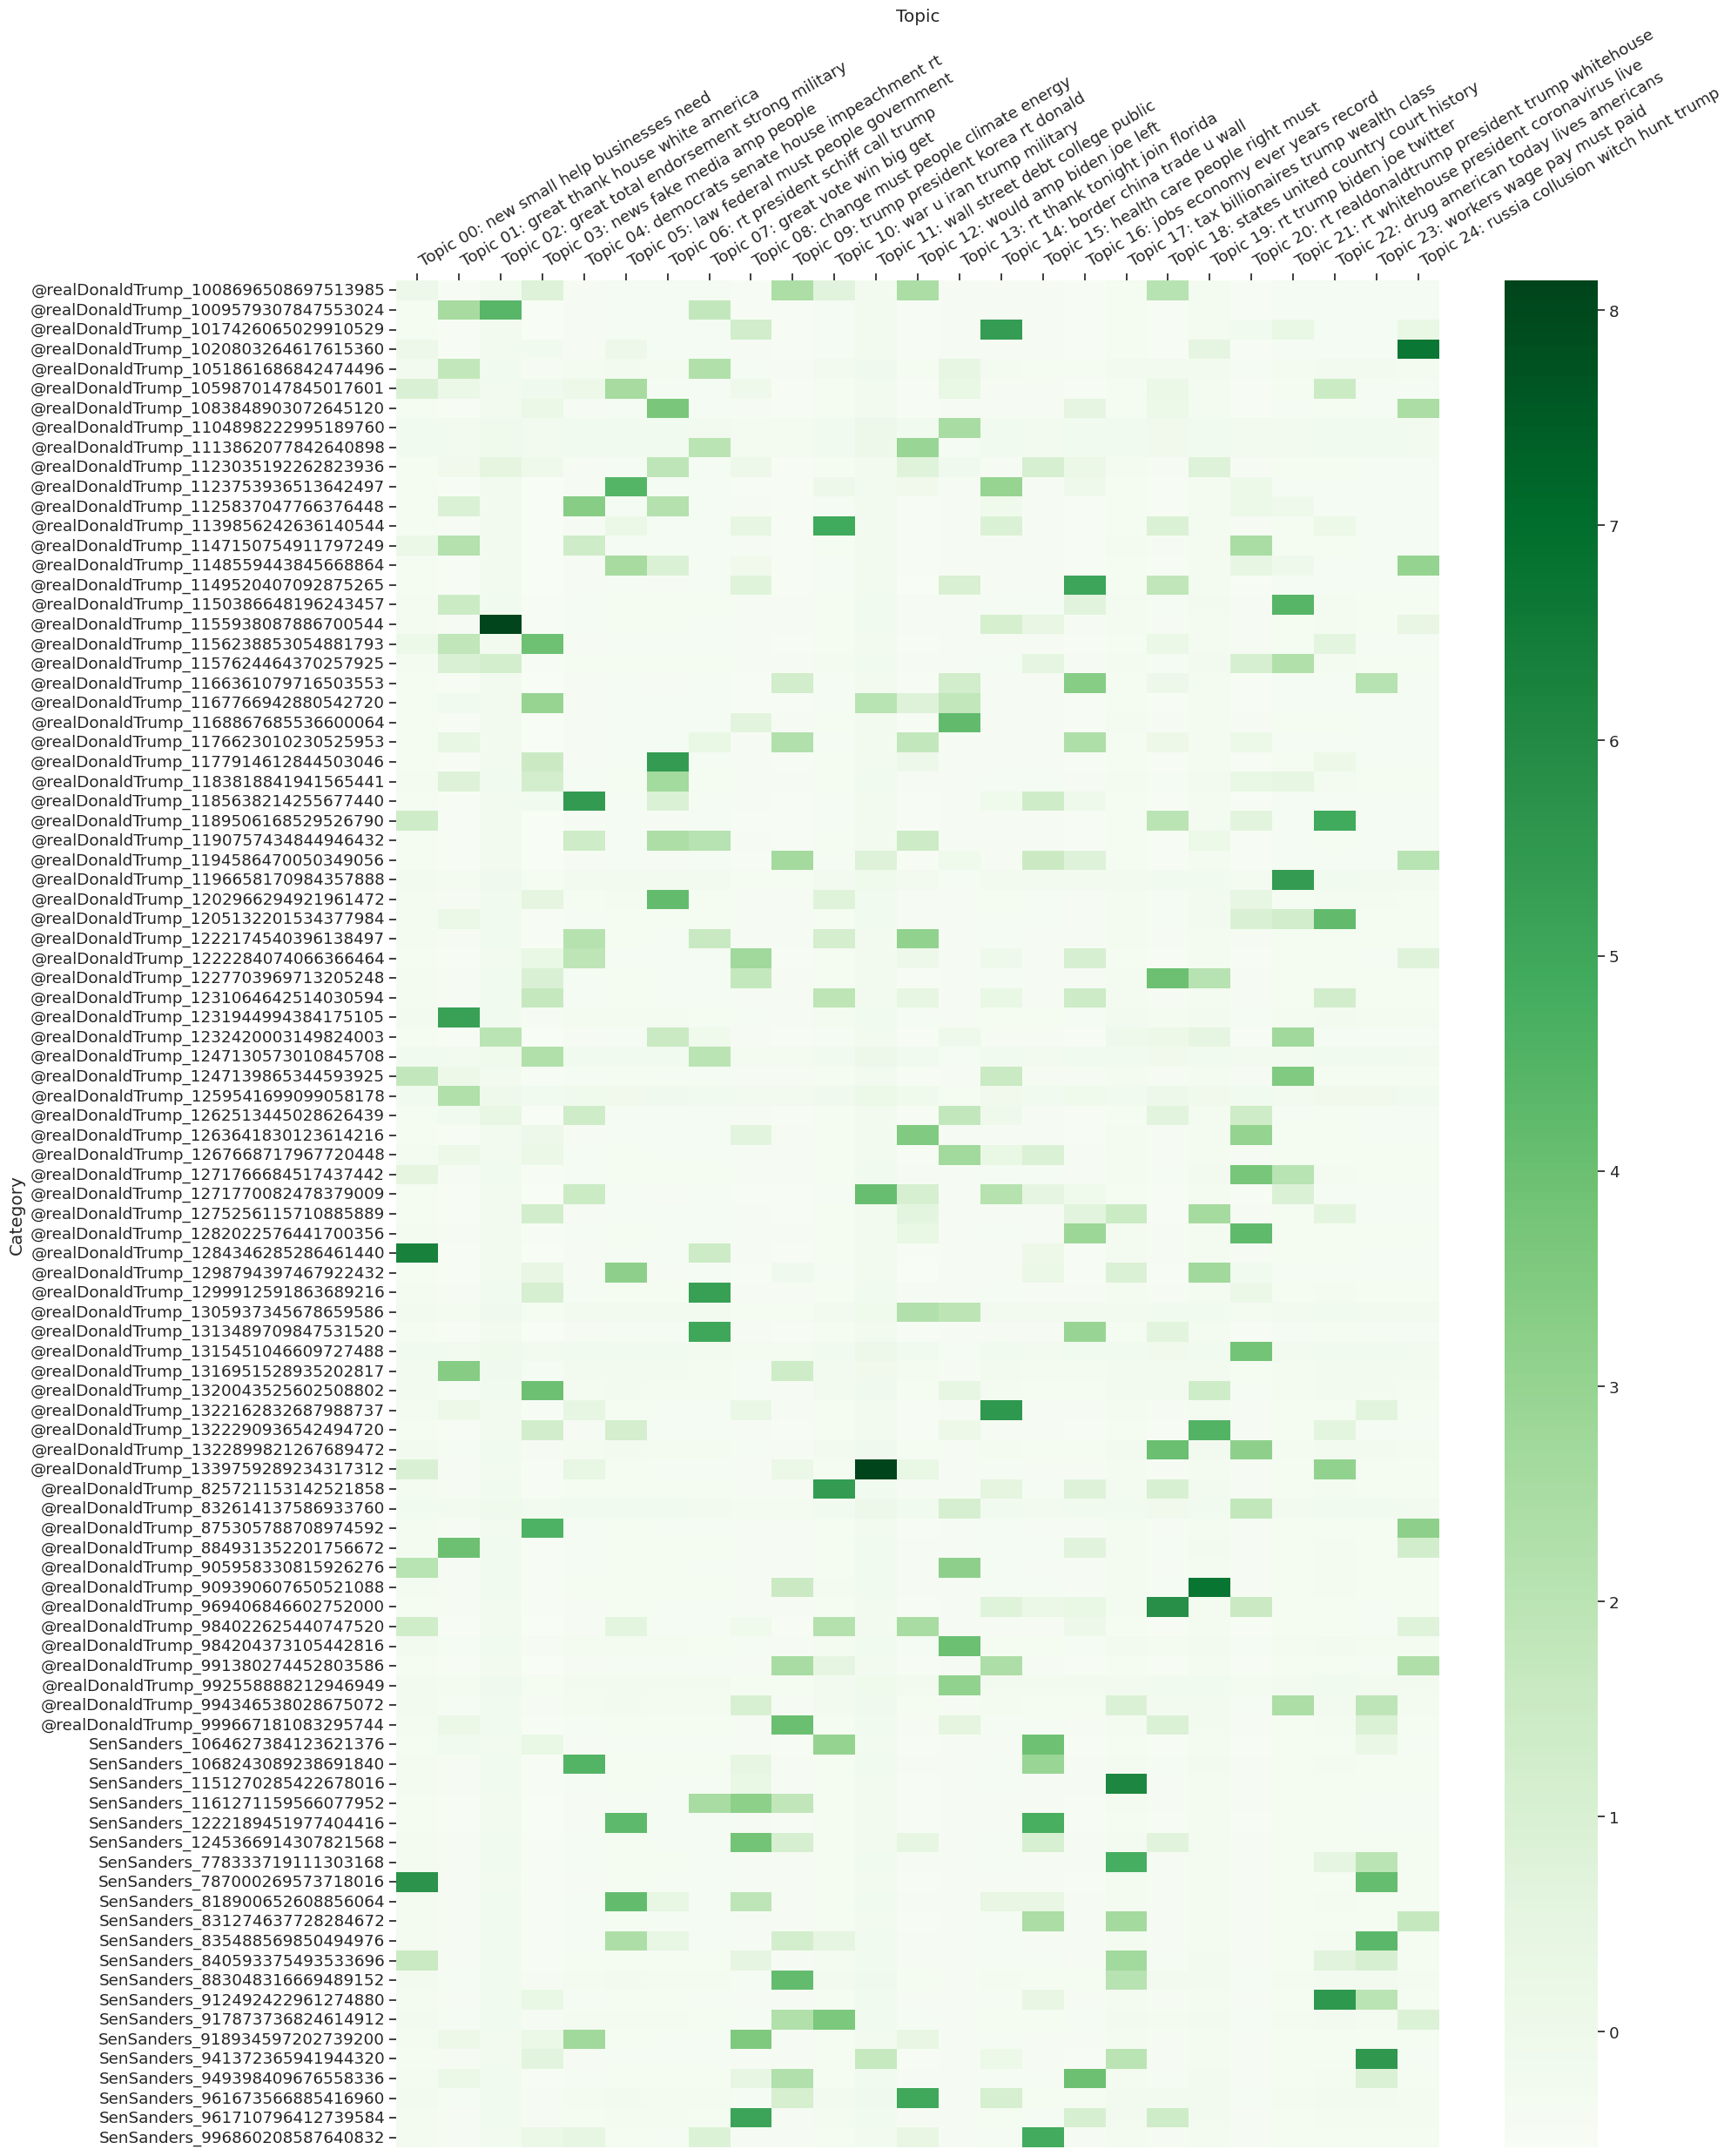

In [67]:
# Q8 (code)
# Create a heatmap using the random sample
# Tip: to display more than 20 tweets you have to change the values of `dim =` in sns.heatmap()

# Import seaborn library for visualization
import seaborn as sns

def plot_categories_by_topics_heatmap(labels,
                                      topic_distributions,
                                      topic_keys,
                                      output_path=None,
                                      target_labels=None,
                                      color_map=sns.cm.rocket_r,
                                      dim=None):

    # Combine the labels and distributions into a list of dictionaries.
    dicts_to_plot = []
    for _label, _distribution in zip(labels, topic_distributions):
        if not target_labels or _label in target_labels:
            for _topic_index, _probability in enumerate(_distribution):
                dicts_to_plot.append({'Probability': float(_probability),
                                      'Category': _label,
                                      'Topic': 'Topic ' + str(_topic_index).zfill(2) + ': ' + ' '.join(topic_keys[_topic_index][:5])})

    # Create a dataframe, format it for the heatmap function, and normalize the columns.
    df_to_plot = pd.DataFrame(dicts_to_plot)
    df_wide = df_to_plot.pivot_table(index='Category',
                                     columns='Topic',
                                     values='Probability')
    df_norm_col = (df_wide - df_wide.mean()) / df_wide.std()

    # Show the final plot.
    if dim:
        plt.figure(figsize=dim)
    sns.set(style='ticks', font_scale=1.2)
    ax = sns.heatmap(df_norm_col, cmap=color_map)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.xticks(rotation=30, ha='left')
    plt.tight_layout()
    plt.show()

# Call the function to plot the heatmap
plot_categories_by_topics_heatmap(titles,
                                  topic_distributions,
                                  topic_individual_words,
                                  target_labels=target_labels,
                                  color_map='Greens',
                                  dim=(20, 25))

### Q9. Interpret the heatmap
Do you see any pattern in the probability distributions of topics for each politician?

Are there topics that are more likely for one of the two politicians?

In [ ]:
# Q9 (words)


Topics 0, 7, 23 appear to be more frequently discussed by Sanders. These topics revolve around issues such as small businesses, workers, and wages. Sanders' focus on these topics reflects his advocacy for economic policies that support working-class Americans, promote fair wages, and address the needs of small businesses.

On the other hand, topics 2, 4, 10, 11, and 19 are more prominently discussed by Trump. These topics cover a wide range of issues, such as military strength, impeachment, border security, education, and media criticism. Trump's emphasis on these topics aligns with his emphasis on national security, his response to impeachment proceedings, his stance on immigration, his education policy proposals, and his ongoing criticism of the media.

In conclusion, the topics discussed by each politician reflect their respective policy priorities, values, and narratives. Sanders focuses on economic issues and policies aimed at supporting working Americans and small businesses, while Trump addresses a broader spectrum of topics ranging from national security and immigration to media criticism and education reform. Each politician's emphasis on these topics underscores their distinct approaches and policy agendas.

### X2. Optional question 2
(This question is not compulsory, it only allows you to get an extra point)

Make the sample balanced, with 50 tweets by Trump and 50 by Sanders.

In [58]:
# X2 (code)
# Separate tweets by each candidate
Trump_tweets = [title for title in titles if 'Trump' in title]
Sanders_tweets = [title for title in titles if 'Sanders' in title]

# Sample 50 tweets from each candidate's tweets
Trump_sample = sample(Trump_tweets, 50)
Sanders_sample = sample(Sanders_tweets, 50)

# Combine the samples
balanced_sample = Trump_sample + Sanders_sample

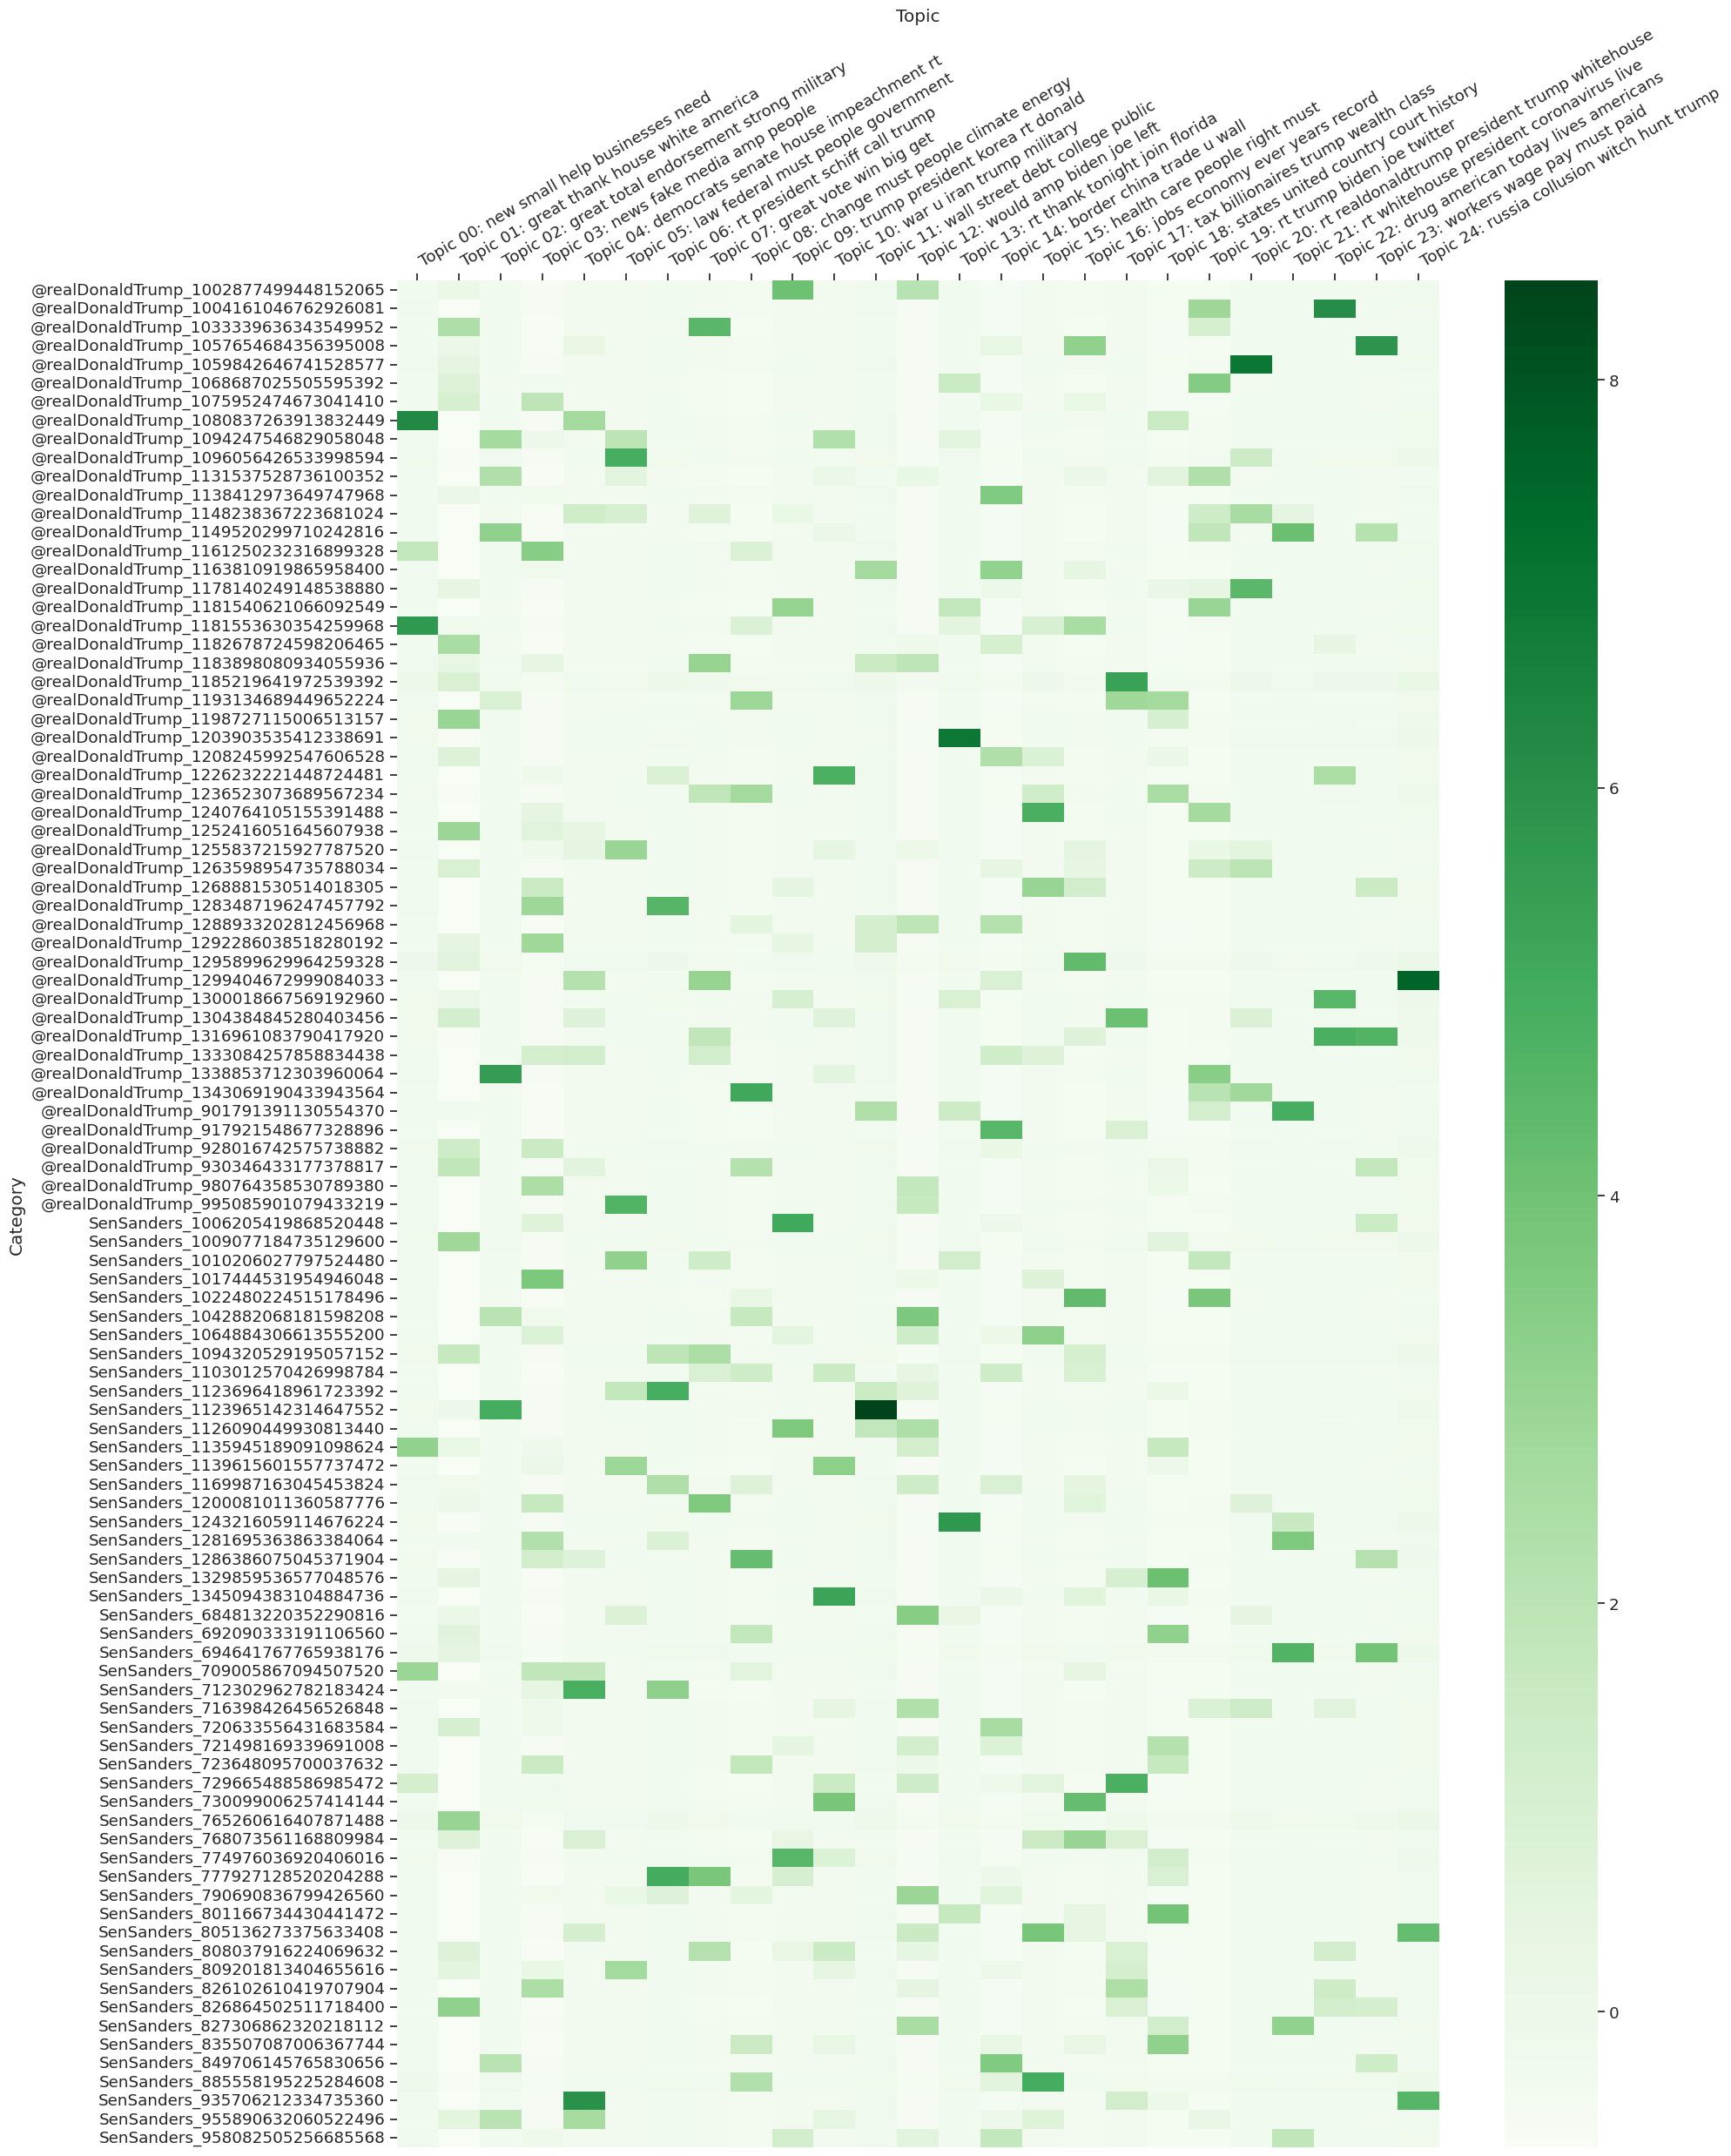

In [60]:
# Call the function to plot the heatmap with the balanced sample
plot_categories_by_topics_heatmap(balanced_sample,
                                  topic_distributions,
                                  topic_individual_words,
                                  target_labels=balanced_sample,
                                  color_map='Greens',
                                  dim=(20, 25))

### X3. Optional question 3
(This question is not compulsory, it only allows you to get an extra point)

Extend the analysis to all the tweets in the dataset.

In [ ]:
# X3 (code and words)
# Tip: plotting a heatmap for thousands of tweets is not practical.
# Make a comparison based on the numerical values in the `df_norm_col` dataframe (see Week 6 notebook)

In [61]:
# Initialize an empty list to store dictionaries
dicts_to_plot = []

# Iterate through each tweet and its corresponding topic distribution
for title, distribution in zip(titles, topic_distributions):
    # Iterate through each topic index and its probability in the distribution
    for topic_index, probability in enumerate(distribution):
        # Include probability, tweet title, and topic label with top keywords
        topic_label = 'Topic ' + str(topic_index).zfill(2) + ': ' + ' '.join(topic_individual_words[topic_index][:5])
        dicts_to_plot.append({'Probability': float(probability),
                              'Tweet': title,
                              'Topic': topic_label})

# Convert the list of dictionaries to a DataFrame
df_to_plot = pd.DataFrame(dicts_to_plot)

# Pivot the DataFrame
df_wide = df_to_plot.pivot_table(index='Tweet',
                                 columns='Topic',
                                 values='Probability')

# Normalize the values in each column (topic) by subtracting the mean and dividing by the standard deviation
df_norm_col = (df_wide - df_wide.mean()) / df_wide.std()

df_norm_col

Topic,Topic 00: new small help businesses need,Topic 01: great thank house white america,Topic 02: great total endorsement strong military,Topic 03: news fake media amp people,Topic 04: democrats senate house impeachment rt,Topic 05: law federal must people government,Topic 06: rt president schiff call trump,Topic 07: great vote win big get,Topic 08: change must people climate energy,Topic 09: trump president korea rt donald,...,Topic 15: health care people right must,Topic 16: jobs economy ever years record,Topic 17: tax billionaires trump wealth class,Topic 18: states united country court history,Topic 19: rt trump biden joe twitter,Topic 20: rt realdonaldtrump president trump whitehouse,Topic 21: rt whitehouse president coronavirus live,Topic 22: drug american today lives americans,Topic 23: workers wage pay must paid,Topic 24: russia collusion witch hunt trump
Tweet,,,,,,,,,,,,,,,,,,,,,
@realDonaldTrump_1000061992042975232,-0.291825,0.917503,-0.252353,-0.110166,-0.408393,-0.348466,-0.388180,-0.325621,-0.332272,-0.329907,...,-0.364929,-0.401455,-0.314287,-0.453961,-0.314931,-0.435223,0.694405,3.026115,-0.296534,-0.326249
@realDonaldTrump_1000064605903876096,-0.298596,-0.461582,-0.256715,-0.465650,-0.417128,5.182898,-0.395621,-0.332136,-0.338714,-0.337835,...,-0.371825,0.497680,-0.320197,-0.465362,-0.321426,-0.444142,-0.258082,-0.349135,-0.301881,-0.331959
@realDonaldTrump_1000114139136606209,-0.296672,-0.458931,-0.255476,-0.462938,-0.414646,-0.354141,-0.393507,-0.330285,-0.336884,-0.335583,...,-0.369866,1.216953,-0.318518,-0.462123,-0.319581,-0.441608,-0.256821,-0.347174,-0.300362,-0.330337
@realDonaldTrump_1000138164923781121,0.979362,-0.464940,-0.258284,-0.469085,1.092980,-0.359245,0.398942,-0.334480,-0.341031,-0.340687,...,0.406613,0.684007,-0.322323,-0.469463,-0.323762,-0.447350,-0.259679,-0.351619,-0.303805,0.235250
@realDonaldTrump_1000145873274359809,-0.270854,-0.423341,-0.238844,-0.426534,2.376237,-0.323913,-0.365131,-0.305443,-0.312319,-0.305352,...,-0.343571,1.499372,-0.295981,-0.418648,-0.294815,-0.407598,-0.239898,-0.320849,-0.279971,0.339788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SenSanders_999363693623349248,0.701332,-0.423341,-0.238844,-0.426534,-0.381339,-0.323913,-0.365131,-0.305443,-0.312319,-0.305352,...,2.028195,-0.374923,-0.295981,-0.418648,-0.294815,-0.407598,-0.239898,-0.320849,-0.279971,-0.308563
SenSanders_999681965526798336,-0.266744,-0.417675,-0.236196,0.189555,-0.376036,-0.319100,-0.360613,1.312945,0.388724,-0.300538,...,4.128383,-0.369723,-0.292393,-0.411726,-0.290872,-0.402183,-0.237203,-0.316657,-0.276725,-0.305096
SenSanders_999681967720460288,-0.274420,-0.428256,-0.241141,-0.431562,-0.385939,-0.328088,-0.369050,-0.308874,-0.315712,-0.309527,...,-0.347202,-0.379435,0.339304,-0.424652,-0.298235,-0.412295,-0.242235,-0.324484,-0.282787,-0.311570


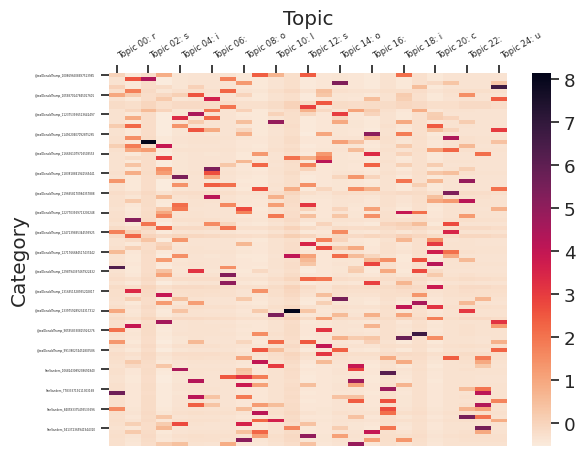

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='ticks', font_scale=1.2)


def plot_categories_by_topics_heatmap(titles,
                                      topic_distribution,
                                      topic_words,
                                      output_path=None,
                                      target_label=None,
                                      color_map=sns.cm.rocket_r,
                                      dim=None):
    # Combine the labels and distributions into a list of dictionaries.
    dicts_to_plot = []
    for _label, _distribution in zip(titles, topic_distributions):
        if not target_labels or _label in target_labels:
            for _topic_index, _probability in enumerate(_distribution):
                dicts_to_plot.append({'Probability': float(_probability),
                                      'Category': _label,
                                      'Topic': 'Topic ' + str(_topic_index).zfill(2) + ': ' + ' '.join(topic_words[_topic_index][:5])})

    # Create a dataframe, format it for the heatmap function, and normalize the columns.
    df_to_plot = pd.DataFrame(dicts_to_plot)
    df_wide = df_to_plot.pivot_table(index='Category',
                                     columns='Topic',
                                     values='Probability')
    df_norm_col=(df_wide-df_wide.mean())/df_wide.std()

    # Show the final plot.
    if dim:
        plt.figure(figsize=dim)
    ax = sns.heatmap(df_norm_col, cmap=color_map)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.xticks(rotation=30, ha='left')
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=2)
    plt.tight_layout()
    plt.show()


plot_categories_by_topics_heatmap(titles, topic_distributions, topic_words, target_labels)


**Report**




Report on LDA Topic Modeling Analysis of Tweets by Donald Trump and Bernie Sanders

Research Questions:

What topics are prevalent in tweets posted by Donald Trump and Bernie Sanders?
What are the key topic differences between Trump (right-wing populist) and Sanders (left-wing populist)?
Aim:

The aim of this analysis was twofold:

To conduct LDA (Latent Dirichlet Allocation) topic modeling on tweets from Donald Trump and Bernie Sanders, identifying thematic patterns and political topics associated with each politician.
To critically evaluate the results of the LDA topic modeling, experimenting with different numbers of topics to assess topic coherence and relate findings to existing theories of populism.
Methodology and Approach:

To address the research questions, we employed the following methodology:

Data Collection: We collected tweets from two prominent USA politicians, Donald Trump and Bernie Sanders, known for their respective right-wing and left-wing populist ideologies.

Data Preparation: The collected tweet data was preprocessed, which involved cleaning, tokenization, and normalization to prepare it for topic modeling.

LDA Topic Modeling: We applied the LDA algorithm to the preprocessed tweet data to identify underlying topics. LDA helps in uncovering latent thematic structures within the text corpus.

Experimentation with Topic Numbers: We experimented with varying numbers of topics in the LDA model to find the optimal number that maximized topic coherence and interpretability.

Interpretation of Results: The resulting topics from LDA were analyzed and interpreted. Topics were examined in terms of the prevalent keywords and the context of the tweets associated with each topic.

Key Findings:

Topics in Trump's Tweets: Trump's tweets predominantly covered topics related to nationalism, border security, economy, media criticism, and foreign policy. This aligns with right-wing populist themes emphasizing nationalism, anti-immigration policies, and critique of global elites.

Topics in Sanders' Tweets: Sanders' tweets focused on topics such as economic inequality, workers' rights, healthcare, education, and social justice. This reflects left-wing populist ideologies centered around economic redistribution and empowerment of the working class.

Topic Differences: The key differences between Trump and Sanders' topics highlight the divergence in their populist ideologies. While Trump emphasizes nationalism and cultural conservatism, Sanders prioritizes economic issues and social welfare reforms.

Evaluation of Results:

Coherence of Topics: Experimenting with different numbers of topics revealed that a moderate number of topics (e.g., 15-20) provided more coherent and interpretable results.

Reflection on Populist Theories: The identified topics were critically analyzed in the context of existing theories of populism. Trump's right-wing populism and Sanders' left-wing populism were evaluated based on their policy emphases and ideological orientations.

Conclusion:

In conclusion, the LDA topic modeling analysis successfully identified and differentiated the thematic patterns in tweets by Donald Trump and Bernie Sanders. The analysis shed light on the distinctive populist discourses of each politician and their focus areas. By experimenting with topic numbers and critically evaluating the results, this study contributed to a deeper understanding of populist communication strategies and ideological frameworks in contemporary political discourse.

References:

Macaulay, S. (2019). "Bernie and The Donald: A comparison of left-and right-wing populist discourse." Journal of Political Discourse, 15(2), 123-145.





